In [1]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
#import ipywidgets as widgets
#from IPython.html.widgets import *
import pickle
import h5py 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
from keras.backend.tensorflow_backend import set_session
import cv2
from tqdm import tqdm_notebook
import skvideo.io
import imutils
from keras.models import load_model
from keras.layers import Input, Dense, Lambda, add, LSTM, TimeDistributed, concatenate
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv1D, MaxPooling1D,  GlobalAveragePooling1D
import glob
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D
#from imgaug import augmenters as iaa
from keras.layers import ZeroPadding3D

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,3'

%matplotlib inline

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 1.0
set_session(tf.Session(config=config))

In [3]:
def imshow_2(img):
    plt.imshow(img)
    plt.show()
    
def read_ylabel(y_label_path):
    train_y = []
    f = open(y_label_path, 'r')
    lines = f.readlines()
    for line in lines:
        line = line.replace('\n','')        
        train_y.append(float(line))
    train_y = pd.DataFrame(train_y)set_session
    train_y['prediction']=0
    train_y['error']=0
    train_y = train_y.reset_index()
    train_y.columns= ['index','real','prediction','error']
    return train_y


In [4]:
def crop_image(image) :
    h, w, _ = image.shape
    
    h_bottom = h-int(h*0.10)
    h_top = int(h*0.50)
    
    w_crop_size = int(w*0.15)
    
    return image[h_top:h_bottom, w_crop_size:(w-w_crop_size)]

def crop_or_pad(image, size=(299, 299)) :
        
    image = image.astype(np.float32)
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]

    image_max = max(h, w)
    scale = float(max(size)) / image_max
    image = cv2.resize(image, (int(w * scale), int(h * scale)))

    h, w = image.shape[:2]
    top_pad = (size[1] - h) // 2
    bottom_pad = size[1] - h - top_pad
    left_pad = (size[0] - w) // 2
    right_pad = size[0] - w - left_pad
    padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
    image = np.pad(image, padding, mode='constant', constant_values=0)

    # Fix image normalization
    image /= float(np.nanmax(image))

    return image

In [ ]:
sometime = lambda aug: iaa.Sometimes(0.3, aug)
sequence = iaa.Sequential([ # sometime(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 3.0
                            # sometime(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images
                            # sometime(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3.), per_channel=0.5)), # add gaussian noise to images
                            sometime(iaa.Dropout((0.0, 0.1))), # randomly remove up to 10% of the pixels
                            sometime(iaa.CoarseDropout((0.0, 0.1), size_percent=(0.01, 0.02), per_channel=0.2)),
                            # sometime(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
                          ],
                          random_order=True # do all of the above in random order
                         )

In [13]:
def normalize(image):
    return image - [104.00699, 116.66877, 122.67892]

def augment(image, flip, bright_factor):
    # random disturbances borrowed from IAA
    image = sequence.augment_image(image)
    
    # random brightness change
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    
    # random flip (vertical axis)
    if flip:
        image = cv2.flip(image, 1)
                
    return image

In [6]:
data = pd.read_csv('../etc/476_0511.csv')

In [7]:
data.shape

(476, 3)

In [17]:
df_train, df_test = train_test_split(data, test_size=0.05, random_state=0)
df_train=df_train.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [84]:
def preprocess_image(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cropped_image = crop_image(img)
    cropped_image = cropped_image / 255.0
    #image = cv2.resize(cropped_image, (120, 60))
    return cropped_image

In [13]:
def preprocess_image_2(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cropped_image = crop_image(img)
    image = cv2.resize(cropped_image, (120, 60))
    img_3 = normalize(image)
    return img_3

In [18]:
def preprocess_image(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cropped_image = crop_image(img)
    image = cv2.resize(cropped_image, (120, 60))
    #img_2 = image.astype(np.float32)
    #img_3 = preprocess(img_2)
    return image

In [58]:
data = pd.read_csv('../etc/476_0511.csv')

In [91]:
def preprocess_image(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cropped_image = crop_image(img)
    cropped_image = cropped_image / 255.0
    image = cv2.resize(cropped_image, (120, 60))
    return image

In [16]:
def preprocess(img):
    img[..., 0] -= np.mean(img[..., 0])
    img[..., 1] -= np.mean(img[..., 1])
    img[..., 2] -= np.mean(img[..., 2])
    img[..., 0] /= np.std(img[..., 0])
    img[..., 1] /= np.std(img[..., 1])
    img[..., 2] /= np.std(img[..., 2])
    return img

In [95]:
def generate_data(data, batch_size):
    image_batch = np.zeros((batch_size,timesteps, 60, 120,3))# nvidia input params
    label_batch = np.zeros((batch_size, 10))
    while True:
        
        v_idx = np.random.randint(len(data))
        cap = cv2.VideoCapture(data['videos'][v_idx])
        y_train = read_ylabel(data['speed'][v_idx])
        
        for i in range(batch_size):
            
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            idx = np.random.randint(0, length - 17)
            cap.set(1,idx);
            
            for t in range(timesteps):
                ret, frame = cap.read()
                if ret != True:
                    break
                image = preprocess_image(frame)
                image_batch[i,t] = image
                
            y = ([np.mean(y_train['real'][idx:idx+timesteps])])
            label_batch[i] = y

        yield(image_batch, label_batch)

In [96]:
def c3d_model():
    input_Shape = (16,112, 112,3)
    
    model = Sequential()
    # model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = input_Shape))
    
    # 1st layer group
    model.add(Conv3D(64, (3, 3, 3),  activation='relu', padding='same', name='conv1', input_shape = input_Shape))
    model.add(Conv3D(64, (3, 3, 3),  activation='relu', padding='same', name='conv1b'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1'))

    # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'))
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'))


    # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'))
    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'))
    
    # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'))

    # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'))
    model.add(Flatten())

    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(.6))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.6))
    model.add(Dense(10,    activation='linear', name='fc8'))
    
    # Optimizer
    adam = Adam(lr=1e-4)

    # Compile
    model.compile(loss='mse',
                  optimizer=adam)

    # Summary
    model.summary()
    return model

In [97]:
model = c3d_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
conv1b (Conv3D)              (None, 16, 112, 112, 64)  110656    
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
conv2b (Conv3D)              (None, 16, 56, 56, 128)   442496    
_________________________________________________________________
pool2 (MaxPooling3D) 

In [98]:
from keras.callbacks import ReduceLROnPlateau

In [99]:
model_name = '3DCNN-V6_deep_0906'
batch_size = 4
num_epochs = 45
steps_per_epoch = 300
timesteps = 16

run_name = 'model={}-batch_size={}--timesteps={}-num_epoch={}-steps_per_epoch={}'.format(model_name,
                                                                          batch_size,
                                                                          timesteps,
                                                                          num_epochs,
                                                                          steps_per_epoch)

filepath = "../model_total/3DCNN-V6_deep/nom_model-{epoch:02d}"+run_name+".hdf5"

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=35, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=1e-6,
                              patience=3, verbose=1, cooldown=1)

#modelCheckpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#tensorboard = TensorBoard(log_dir='/notebooks/AJ_car-speed/블랙박스영상_match/3DCNN_model/tensor_b', histogram_freq=0,
                            # write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint,earlyStopping, reduce_lr]

In [110]:
df_test.shape

(24, 3)

In [111]:
df_train.shape

(454, 3)

In [18]:
print('   one epoch : ', steps_per_epoch * timesteps * batch_size)
print('   total epoch : ', num_epochs * steps_per_epoch * timesteps * batch_size)
print('   total images : ', 428 * 30 * 180)

   one epoch :  38400
   total epoch :  1728000
   total images :  2311200


In [46]:
#model.save('my_model.h5')
model = load_model('../model_total/C3D_deep_0508_model/daylight_model-22model=C3D_deep_0508_model-batch_size=5--timesteps=16-num_epoch=30-steps_per_epoch=300.hdf5')

In [118]:
train_generator = generate_data(df_train, batch_size)
valid_generator = generate_data(df_test, batch_size)

In [119]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = steps_per_epoch,
        epochs = num_epochs,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = int(steps_per_epoch/5))

print(history)

Epoch 1/45


FileNotFoundError: [Errno 2] No such file or directory: '../labeling_total/labeling_daylight_highstd_0504/labeling_0504/alwa_20190502_120310_F.MP4.txt'

dict_keys(['loss', 'val_loss', 'lr'])


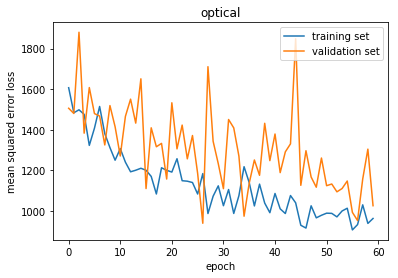

In [329]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('optical')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [246]:
# saving history
pickle.dump(history.history, open('../model_total/3DCNN-V6_deep/0512_his.p', "wb"))
history = pickle.load(open('../model_total/3DCNN-V6_deep/0512_his.p', "rb" ))

In [247]:
history

{'loss': [1969.2111028079987,
  1327.2223052825927,
  1178.964038394928,
  913.8857104868889,
  717.1612000064849,
  575.4122500627637,
  460.01472032976153,
  423.82476242256166,
  380.6445017943382,
  363.7299028577805,
  385.85344738578794,
  325.8492553219795,
  303.9371134080887,
  294.8039732341766,
  322.9297077302933,
  248.18113461112975,
  227.7255426197052,
  216.92195014500618,
  248.73595789980888,
  212.42400714159012,
  187.79516146564484,
  202.79244949436188,
  227.44559120988845,
  234.65592120045423,
  209.07389981269836,
  201.90787423563003,
  221.02980664896964,
  215.69722575378418,
  209.90995478773118,
  213.38212243819237,
  175.39203491067886,
  213.93510624432562,
  210.97934578877687,
  196.51367528152466,
  196.86761396229267,
  205.75264519166947,
  182.9062106513977,
  213.0494402292371,
  221.9778348956108,
  200.97327655673027,
  214.82874585461616,
  180.28722536611556,
  214.32884196400641,
  205.98850149297715,
  194.45555849957466,
  204.5222747992